### This notebook implements :
1. Squeezing input curve to 5 values.
1. Perceptron fitting on data of 4 component task with squeezed input data.
2. KAN fitting on data of 4 component task with squeezed input data.
4. Transformation KAN model to expression analytic functions expression.

---
Functions, that are used in this notebook, are written in modules:
* raw_data_processing.py
* tools.py

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from copy import deepcopy

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import torch
from kan import KAN

In [2]:
from raw_data_processing import get_x, get_y, get_wavelength
from tools import JSON_Read, plotly_multi_scatter

In [3]:
SCRIPT_DIR = os.path.abspath('')

## Loading data

In [4]:
d_config = JSON_Read("", "json_config.txt")
#locals().update(d_config)  # Transfer dict data to variables
d_config

{'SPEC_FOLDER': 'full_data',
 'EXCITE_WAVE_LENGTH': 350,
 'PREDICT_IONS': ['Cr'],
 'TRAIN_TEST_RATIO': 0.9,
 'VALIDATION_TRAIN_RATIO': 0.2857,
 'RANDOM_STATE_SPLIT': 42,
 'N_ITER_NO_CHANGE': 100,
 'HIDDEN_LAYER_SIZES': 500,
 'RANDOM_STATE_TRAIN': 42,
 'ACTIVATION': 'tanh',
 'SOLVER': 'adam',
 'EARLY_STOPPING': True,
 'MAX_ITER': 1000}

In [149]:
EXCITE_WAVE_LENGTH = d_config['EXCITE_WAVE_LENGTH']
PREDICT_IONS = d_config['PREDICT_IONS']
SPEC_FOLDER = d_config['SPEC_FOLDER']

TRAIN_TEST_RATIO = d_config['TRAIN_TEST_RATIO']
VALIDATION_TRAIN_RATIO = d_config['VALIDATION_TRAIN_RATIO']
N_ITER_NO_CHANGE = d_config['N_ITER_NO_CHANGE']

HIDDEN_LAYER_SIZES = d_config['HIDDEN_LAYER_SIZES']
ACTIVATION = d_config['ACTIVATION']
SOLVER = d_config['SOLVER']

In [150]:
x = get_x(wave_length=EXCITE_WAVE_LENGTH, spec_file=""+SPEC_FOLDER)
y = get_y(l_ions=PREDICT_IONS, spec_file=""+SPEC_FOLDER)

In [151]:
x

,251.0,252.0,253.0,254.0,255.0,256.0,257.0,258.0,259.0,260.0,...,741.0,742.0,743.0,744.0,745.0,746.0,747.0,748.0,749.0,750.0
1,2.358,2.249,0.788,2.067,2.199,0.732,1.025,1.716,1.537,0.052,...,2.829,2.543,2.694,3.451,2.910,3.381,3.153,2.326,3.439,3.443
2,5.769,3.680,4.350,5.620,3.090,4.872,3.121,4.202,3.247,2.855,...,3.710,6.719,4.194,4.926,5.587,4.855,5.233,5.584,6.135,7.171
3,2.037,1.928,2.309,2.725,1.803,1.677,1.977,1.857,2.106,1.375,...,3.709,4.711,4.647,5.305,5.232,5.473,5.337,2.666,4.993,3.228
4,3.075,2.551,1.681,1.908,2.565,2.419,2.323,2.013,1.767,2.648,...,5.002,4.668,3.596,4.468,2.947,5.330,3.648,4.799,4.234,4.523
5,1.423,2.238,2.101,2.561,1.994,1.808,1.691,1.662,2.191,1.002,...,5.019,3.541,4.198,5.146,5.086,4.007,5.724,5.749,3.717,4.611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,4.932,2.551,2.051,2.668,1.659,2.705,2.637,1.642,2.294,2.138,...,4.665,3.308,3.899,2.836,3.634,3.602,4.800,4.638,3.036,5.293
997,4.008,3.593,2.359,2.731,2.395,2.859,1.878,2.170,2.887,0.898,...,3.452,4.428,3.616,4.664,4.877,4.359,5.153,3.957,4.406,4.507
998,3.214,2.987,3.374,3.145,2.788,2.231,2.414,1.673,2.372,2.171,...,3.111,3.621,3.163,3.341,4.779,3.578,6.185,3.565,4.193,4.088
999,3.257,2.987,3.121,3.626,1.442,3.501,1.814,2.174,1.252,1.788,...,3.904,3.065,3.455,3.551,3.164,4.492,4.171,3.796,5.633,4.440


# Squeeze input data

In [ ]:
l_wavelenth = get_wavelength(spec_file=""+SPEC_FOLDER)

## Creating new inputs
As squeezed input data we will use:
1. $I$: Maximum intensity value 
2. $c$: Position of maximum intensity
3. $c_h$ : Center position intensity curve on I/2 intensity
4. $wth$ : Width of intensity curve on I/2 intensity
5. $rat$ : Ratio of area under intensity curve on the right from c and on the left from

In [155]:
def get_sqz_input(x_axis, y_axis):
    ''' Evaluate squeezed data from curve.
    '''
    i_max = np.argmax(y_axis)
    I = y_axis[i_max]  # Max I
    c_I = x_axis[i_max]  # Coordinate of max I

    diff_I = np.absolute(y_axis-I/2)
    c_I2_left = x_axis[ np.argmin(diff_I[:i_max]) ]  # Left I/2 coordinate
    c_I2_right = x_axis[ np.argmin(diff_I[i_max:])+i_max]  # Right I/2 coordinate

    c_I2 = np.mean([c_I2_left, c_I2_right])  # Mean center coordinate on I/2 
    disp_I2 = np.abs(c_I2_right-c_I2_left)  # Width of curve on I/2 y-level

    integr_ratio = np.sum(y_axis[i_max+1:]) / np.sum(y_axis[:i_max])

    sqz_input = [I, c_I, c_I2, disp_I2, integr_ratio]
    
    
    return sqz_input

In [156]:
x_axis, y_axis = l_wavelenth, x.loc[x.index[0]].values

get_sqz_input(x_axis, y_axis)

[903.693, 442.0, 448.0, 74.0, 1.675796089555411]

In [157]:
def get_all_sqz_input(matr_x, matr_y):
    matr_sqz_input = []
    for x_axis, y_axis in zip(matr_x, matr_y):
        matr_sqz_input.append(get_sqz_input(x_axis, y_axis))


    return np.array(matr_sqz_input)

In [158]:
x_matrix, y_matrix = np.broadcast_to(l_wavelenth, (len(x), len(l_wavelenth))), x.to_numpy()

x = get_all_sqz_input(x_matrix, y_matrix)

## Scaling data
Train / Validation / Test = 0.7 / 0.2 / 0.1

TRAIN_TEST_RATIO = (Train+Validation) / (Train+Validation+Test)

VALIDATION_TRAIN_RATIO = Validation / Train

In [159]:
RS = None

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    train_size=TRAIN_TEST_RATIO,
                                                    random_state=RS)

In [160]:
x_train.shape, x_test.shape

((900, 5), (100, 5))

In [161]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Model - MLP

Ordinary one-hidden-layer with 500 neurons perceptron.
We use MLPRegressor from scikit-learn library.

In [162]:
model = MLPRegressor(hidden_layer_sizes=HIDDEN_LAYER_SIZES,
                     activation=ACTIVATION,
                     solver=SOLVER,
                     early_stopping=True,
                     validation_fraction=VALIDATION_TRAIN_RATIO,
                     n_iter_no_change=N_ITER_NO_CHANGE, 
                     learning_rate='adaptive')

In [163]:
# Обучение модели на тренировочных данных
model.fit(x_train, y_train)

c:\Users\Gavriil\VS_projects\KAN_spectroscopy\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



MLPRegressor(activation='tanh', early_stopping=True, hidden_layer_sizes=500,
             learning_rate='adaptive', n_iter_no_change=100,
             validation_fraction=0.2857)

In [166]:
def scatter_prediction(model, 
                       x, 
                       y_true, 
                       title = ""):
    """Evaluates MSE and R^2 of model. 
    Draws scatter plot of (y_true, y_predicted).
    Returns  (mse, r2)
    """
    y_pred = model.predict(x)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(5,5))
    plt.plot(y_true, y_pred, 'o', markersize=2, alpha = 0.2) 
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], markersize=2, alpha = 0.5, color='r') 
    ax.set_title(f"MSE={round(mse, 5)} | RMSE={round(mse**0.5, 5)} | R2={round(r2, 5)} | {title}")
    ax.set_xlabel("y_true")
    ax.set_ylabel("y_pred")
    plt.show()
    
    return mse, r2

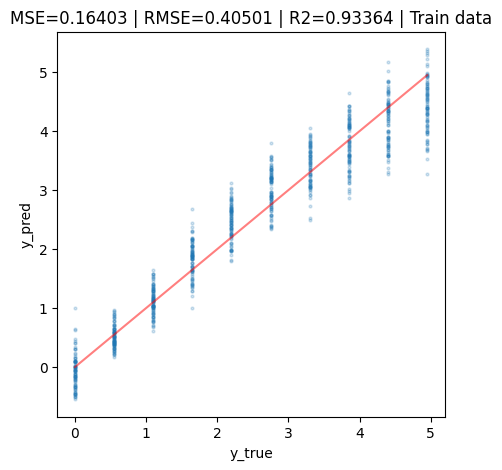

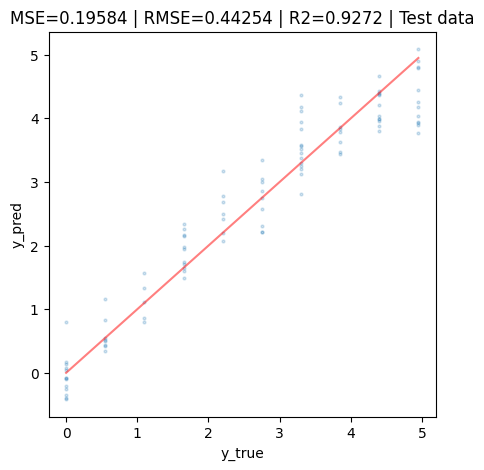

(0.1958372383595285, 0.9271967264981673)

In [167]:
scatter_prediction(model, x_train, y_train, "Train data")
scatter_prediction(model, x_test, y_test, "Test data")

## KAN

New ML architecture, alternative to neural networks. Relies on the Kolmagprov-Arnold theorem about decomposition of function with many parameters:
$$ f(x_{1},\cdot\cdot\cdot, x_{n})\sum_{q=1}^{2n+1}\Phi_{q}(\sum_{p=1}^{n}\varphi_{q,p}(x_{p})) $$

The main idea - represent $\Phi_{q}(\cdot)$ and $\varphi_{q,p}(\cdot)$ as a B-splines, and optimize their parameters during training.
After training it is possible to fit $\Phi_{q}(\cdot)$ and $\varphi_{q,p}(\cdot)$ by analytic formulas, post-train and express received KAN model as regular expression with analytic functions.


Some hyperparameteres of KANs (not all):
- grid: Number of grid intervals. 

Each function in KAN is represented in B-splines - in other words sum of polynoms, located on certain area of input parametere. Grid defines number of training parameteres and complexity of model. Number of grids can be gradually increased during training KAN - provided in "Gradially increasing grid" section.

- k: Order of piecewise polynomial in B-splines. k=3 provides smooth small order polynoms.

In [174]:
RS = None

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    train_size=TRAIN_TEST_RATIO,
                                                    random_state=RS)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

tc_x_train = torch.from_numpy(x_train)
tc_y_train = torch.from_numpy(y_train.reshape([-1,1]))
tc_x_test = torch.from_numpy(x_test)
tc_y_test = torch.from_numpy(y_test).reshape([-1,1])

dataset = {'train_input': tc_x_train,
           'train_label': tc_y_train,
           'test_input': tc_x_test,
           'test_label': tc_y_test}

In [178]:
# Some constants
K = 3 # order of piecewise polynomial in B-splines
INPUT_SHAPE = tc_x_test.shape[1]

In [179]:
def scatter_prediction_kan(model, 
                           x, 
                           y_true, 
                           title = ""):
    """Evaluates MSE and R^2 of model. 
    Draws scatter plot of (y_true, y_predicted).
    Returns  (mse, r2)
    """
    y_pred = model.forward(x).detach().numpy()
    y_true = y_true.detach().numpy()
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(5,5))
    plt.plot(y_true, y_pred, 'o', markersize=2, alpha = 0.2) 
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], markersize=2, alpha = 0.5, color='r') 
    ax.set_title(f"MSE={round(mse, 5)} | RMSE={round(mse**0.5, 5)} | R2={round(r2, 5)} | {title}")
    ax.set_xlabel("y_true")
    ax.set_ylabel("y_pred")
    plt.show()
    
    return mse, r2

## Grid = 3 | hidden neurons = 1

In [254]:
model1 = KAN(width=[INPUT_SHAPE, 1, 1], grid=3, k=K)
'''
model(dataset['train_input'])
model.plot(beta=100)
'''

"\nmodel(dataset['train_input'])\nmodel.plot(beta=100)\n"

In [255]:
result1 = model1.train(dataset, opt="LBFGS", steps=20)

train loss: 3.21e-01 | test loss: 4.03e-01 | reg: 6.36e+00 : 100%|██| 20/20 [00:13<00:00,  1.53it/s]


Text(0.5, 0, 'step')

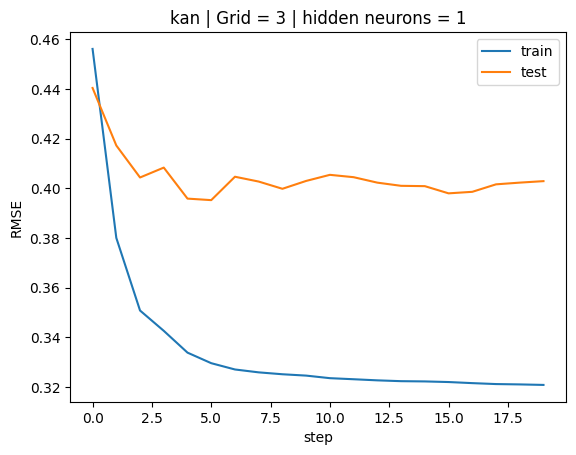

In [256]:
plt.plot(result1['train_loss'])
plt.plot(result1['test_loss'])
plt.legend(['train', 'test'])
plt.title('kan | Grid = 3 | hidden neurons = 1')
plt.ylabel('RMSE')
plt.xlabel('step')

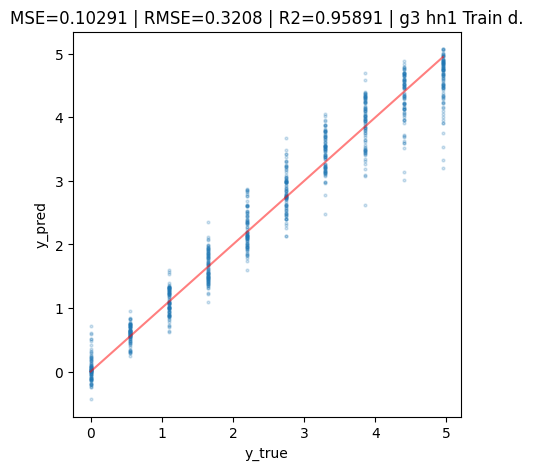

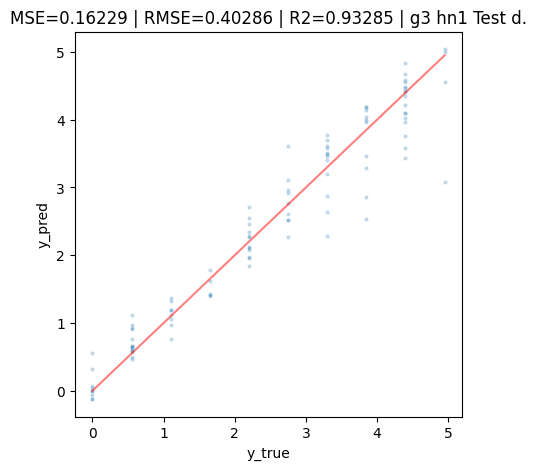

(0.1622938570624627, 0.9328491265659975)

In [257]:
scatter_prediction_kan(model1, tc_x_train, tc_y_train, "g3 hn1 Train d.")
scatter_prediction_kan(model1, tc_x_test, tc_y_test, "g3 hn1 Test d.") 

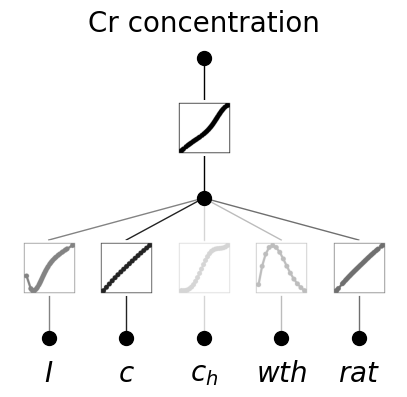

In [278]:
VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
prnt_kwrgs = {'in_vars': VAR, 
                'out_vars': [PREDICT_IONS[0] + ' concentration'], 
                'title': None,
                'sample':True }

model1.plot(**prnt_kwrgs)

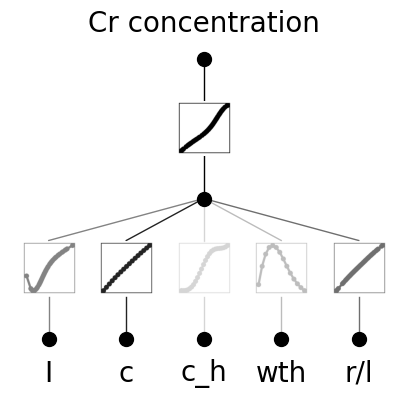

In [259]:
model1.prune()
model1.plot(**prnt_kwrgs)

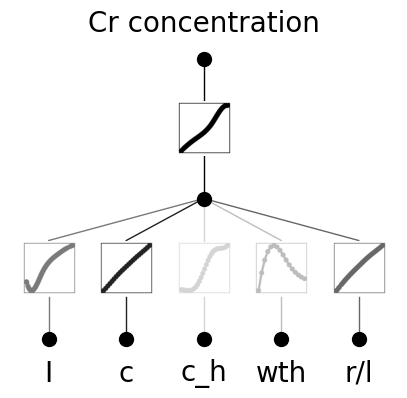

In [266]:
model1_sym = model1.prune()

model1_sym(dataset['train_input']) # it's important to do a forward first to collect activations
model1_sym.plot(**prnt_kwrgs)

function , r2
tanh , 0.9995420698709444
sigmoid , 0.9995420540340186
arctan , 0.9984455381287289
sin , 0.9967296810149483
gaussian , 0.9953196193440714


('tanh',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.9995420698709444)

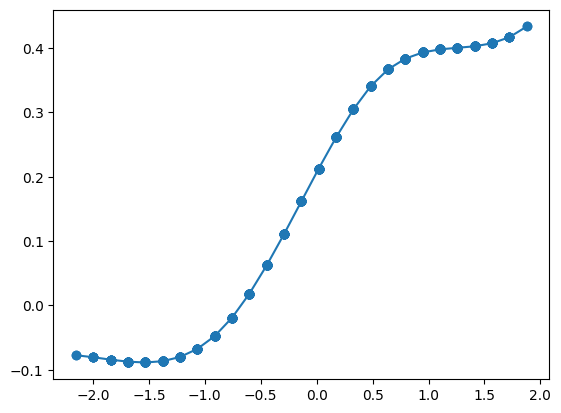

In [267]:
l = 0#1
i = 2#0
j = 0#0

inputs = model1_sym.spline_preacts[l][:,j,i]
outputs = model1_sym.spline_postacts[l][:,j,i]
# they are not ordered yet
rank = np.argsort(inputs)
inputs = inputs[rank]
outputs = outputs[rank]
plt.plot(inputs, outputs, marker="o")

model1_sym.suggest_symbolic(l,i,j)

In [268]:
# now let's replace every activation function with its top 1 symbolic suggestion. This is implmented in auto_symbolic()
model1_sym.auto_symbolic()

# if the user wants to constrain the symbolic space, they can pass in their symbolic libarary
# lib = ['sin', 'x^2', 'exp']
# model.auto_symbolic(lib=lib)

fixing (0,0,0) with gaussian, r2=0.9929457659833905
fixing (0,1,0) with tan, r2=0.9999457423719612
fixing (0,2,0) with tanh, r2=0.9995420698709444
fixing (0,3,0) with gaussian, r2=0.9340165377036281
fixing (0,4,0) with x^4, r2=0.9999150997073201
fixing (1,0,0) with arctan, r2=0.9972841142241395


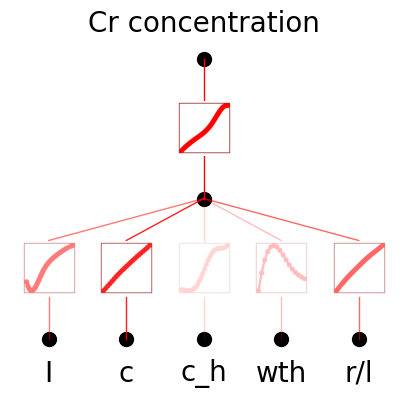

In [269]:
model1_sym.plot(**prnt_kwrgs)

train loss: 3.40e-01 | test loss: 4.03e-01 | reg: 6.41e+00 : 100%|██| 20/20 [00:02<00:00,  9.38it/s]


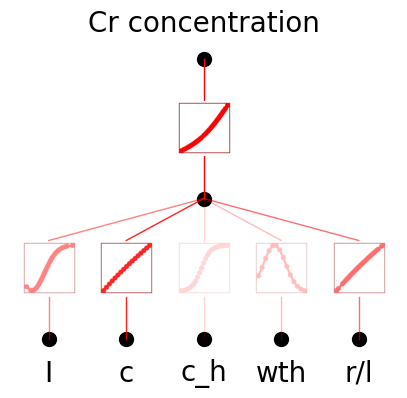

In [270]:
model1_sym.train(dataset, opt="LBFGS", steps=20)
model1_sym.plot(**prnt_kwrgs)

In [273]:
# obtaining symbolic formula
formula, variables  = model1_sym.symbolic_formula(var=VAR)
formula[0]

5.02*atan(-4.51*(1 - 0.03*r/l)**4 + 7.16*tan(0.11*c - 9.74) + 0.13*tanh(1.4*c_h + 0.21) + 6.82 + 0.12*exp(-0.59*(-wth - 0.65)**2) - 0.91*exp(-0.55*(-0.75*I - 1)**2)) + 4.84

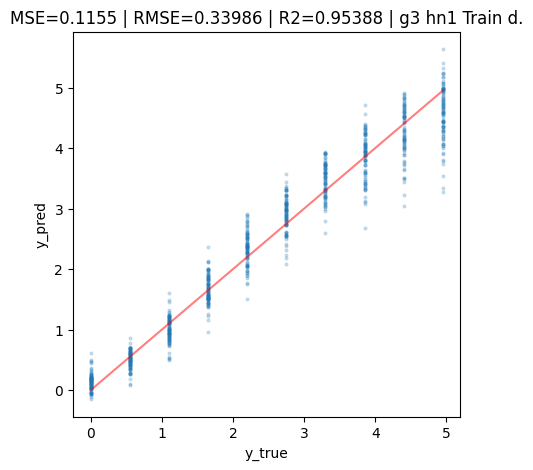

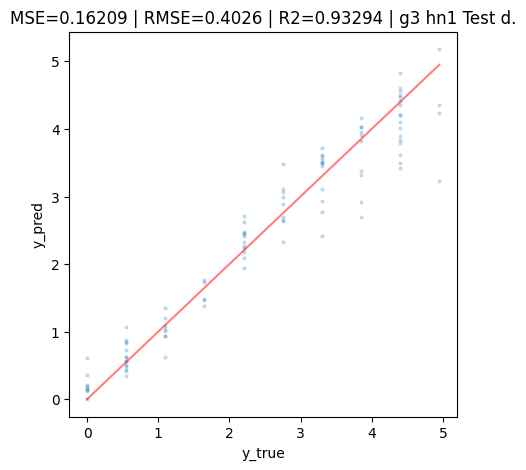

(0.16208586357407234, 0.9329351861659528)

In [276]:
scatter_prediction_kan(model1_sym, tc_x_train, tc_y_train, "g3 hn1 Train d.")
scatter_prediction_kan(model1_sym, tc_x_test, tc_y_test, "g3 hn1 Test d.") 

-----
# Exploration code (main results are presented upper)

### Gradially increasing grid

In [184]:
width = [INPUT_SHAPE, 1, 1]
grids = np.array([3, 5, 7, 10])

train_losses = []
test_losses = []
steps = 10

for i in range(grids.shape[0]):
    if i == 0:
        model1_10 = KAN(width=width, grid=grids[i], k=K)
    if i != 0:
        model1_10 = KAN(width=width, grid=grids[i], k=K).initialize_from_another_model(model1_10, dataset['train_input'])
    results = model1_10.train(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=30)
    train_losses += results['train_loss']
    test_losses += results['test_loss']

train loss: 3.25e-01 | test loss: 4.06e-01 | reg: 5.84e+00 : 100%|██| 10/10 [00:03<00:00,  3.00it/s]
train loss: 3.18e-01 | test loss: 3.97e-01 | reg: 6.19e+00 : 100%|██| 10/10 [00:03<00:00,  2.74it/s]
train loss: 3.04e-01 | test loss: 4.19e-01 | reg: 5.83e+00 : 100%|██| 10/10 [00:05<00:00,  1.97it/s]
train loss: 2.95e-01 | test loss: 4.26e-01 | reg: 5.76e+00 : 100%|██| 10/10 [00:07<00:00,  1.39it/s]


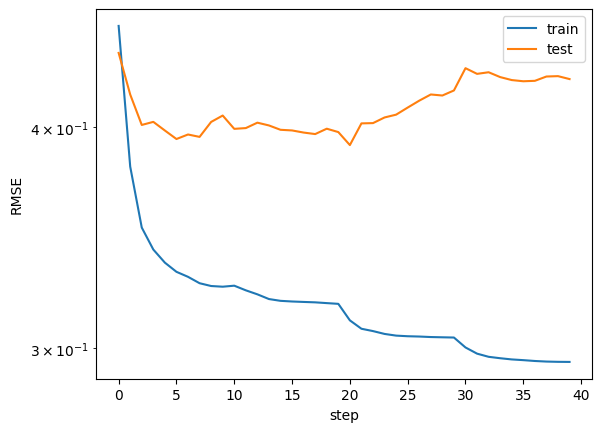

In [185]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

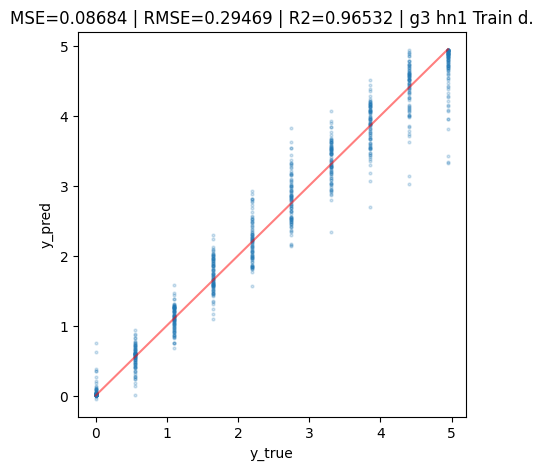

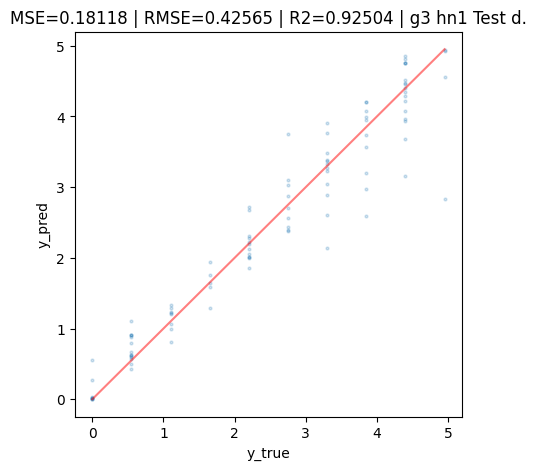

(0.1811777917904237, 0.925035690285626)

In [186]:
scatter_prediction_kan(model1_10, tc_x_train, tc_y_train, "g3 hn1 Train d.")
scatter_prediction_kan(model1_10, tc_x_test, tc_y_test, "g3 hn1 Test d.") 

## Grid = 3 | hidden neurons = 2

In [187]:
model2 = KAN(width=[INPUT_SHAPE, 2, 1], grid=3, k=K)
'''
model(dataset['train_input'])
model.plot(beta=100)
'''

"\nmodel(dataset['train_input'])\nmodel.plot(beta=100)\n"

In [188]:
result2 = model2.train(dataset, opt="LBFGS", steps=20)

train loss: 2.95e-01 | test loss: 4.02e-01 | reg: 8.82e+00 : 100%|██| 20/20 [00:16<00:00,  1.20it/s]


Text(0.5, 0, 'step')

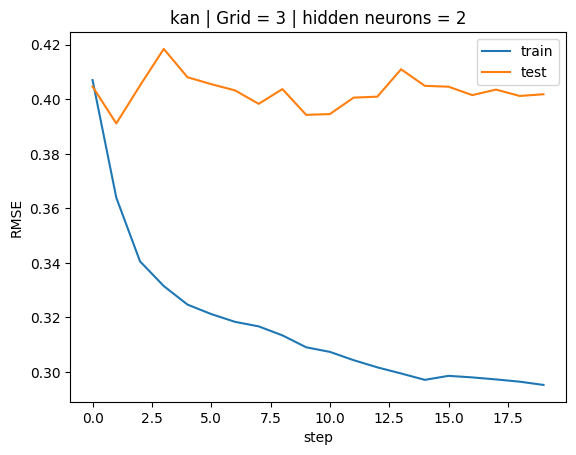

In [189]:
plt.plot(result2['train_loss'])
plt.plot(result2['test_loss'])
plt.legend(['train', 'test'])
plt.title('kan | Grid = 3 | hidden neurons = 2')
plt.ylabel('RMSE')
plt.xlabel('step')

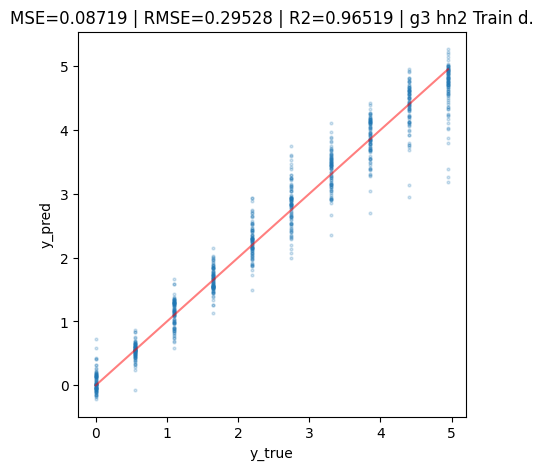

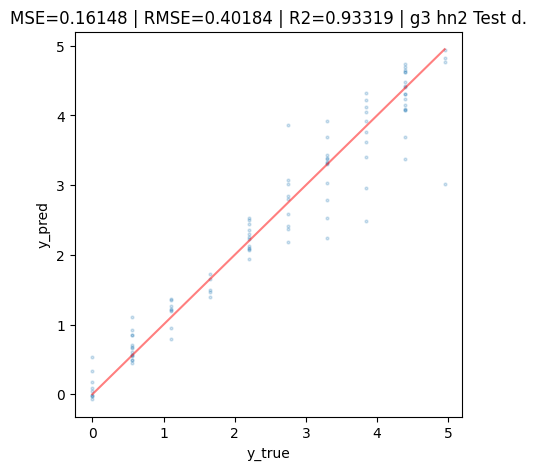

(0.16147653833990702, 0.9331873012023453)

In [190]:
scatter_prediction_kan(model2, tc_x_train, tc_y_train, "g3 hn2 Train d.")
scatter_prediction_kan(model2, tc_x_test, tc_y_test, "g3 hn2 Test d.")

## Grid = 3 | hidden neurons = 5

In [191]:
model5 = KAN(width=[INPUT_SHAPE, 5, 1], grid=3, k=K)
'''
model(dataset['train_input'])
model.plot(beta=100)
'''

"\nmodel(dataset['train_input'])\nmodel.plot(beta=100)\n"

In [192]:
result5 = model5.train(dataset, opt="LBFGS", steps=20)

train loss: 2.84e-01 | test loss: 4.14e-01 | reg: 1.69e+01 : 100%|██| 20/20 [00:30<00:00,  1.52s/it]


Text(0.5, 0, 'step')

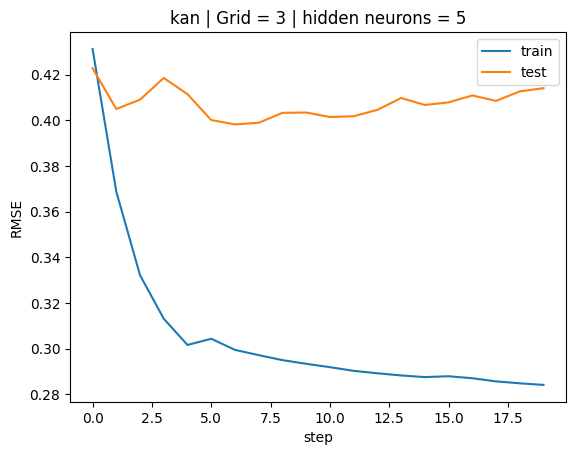

In [193]:
plt.plot(result5['train_loss'])
plt.plot(result5['test_loss'])
plt.legend(['train', 'test'])
plt.title('kan | Grid = 3 | hidden neurons = 5')
plt.ylabel('RMSE')
plt.xlabel('step')

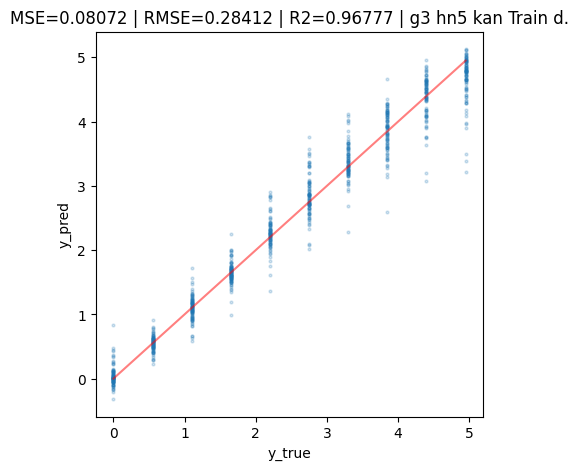

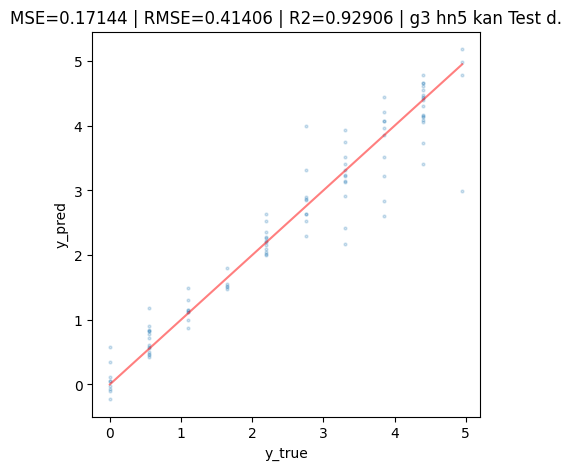

(0.17144472597753835, 0.9290628536198139)

In [194]:
scatter_prediction_kan(model5, tc_x_train, tc_y_train, "g3 hn5 kan Train d.")
scatter_prediction_kan(model5, tc_x_test, tc_y_test, "g3 hn5 kan Test d.")

## Grid=10 | hidden neurons = 5

In [195]:
model5_10 = KAN(width=[INPUT_SHAPE, 5, 1], grid=10, k=K)

result5_10 = model5_10.train(dataset, opt="LBFGS", steps=20)

train loss: 2.19e-01 | test loss: 4.84e-01 | reg: 1.51e+01 : 100%|██| 20/20 [00:37<00:00,  1.88s/it]


Text(0.5, 0, 'step')

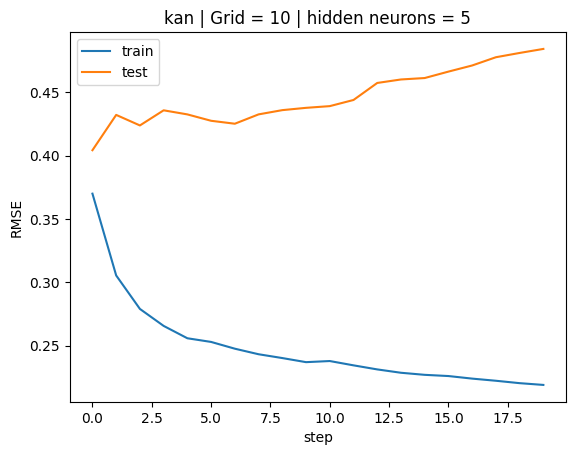

In [196]:
plt.plot(result5_10['train_loss'])
plt.plot(result5_10['test_loss'])
plt.legend(['train', 'test'])
plt.title('kan | Grid = 10 | hidden neurons = 5')
plt.ylabel('RMSE')
plt.xlabel('step')
#plt.yscale('log')

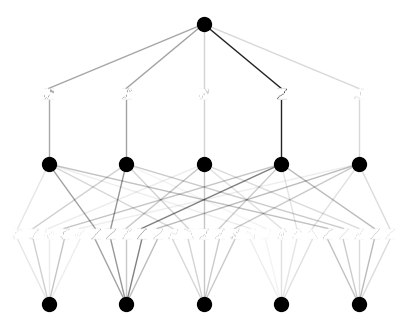

In [197]:
model5_10.plot(beta=3)

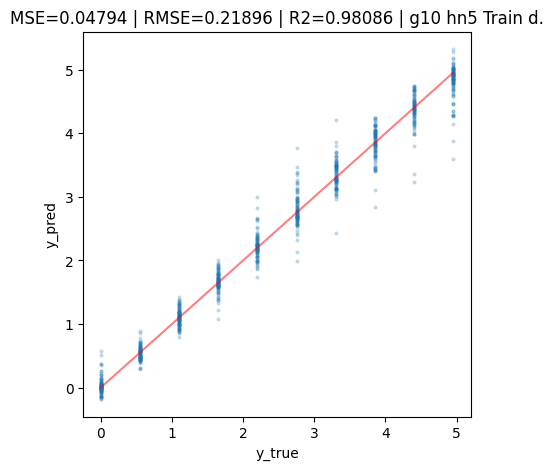

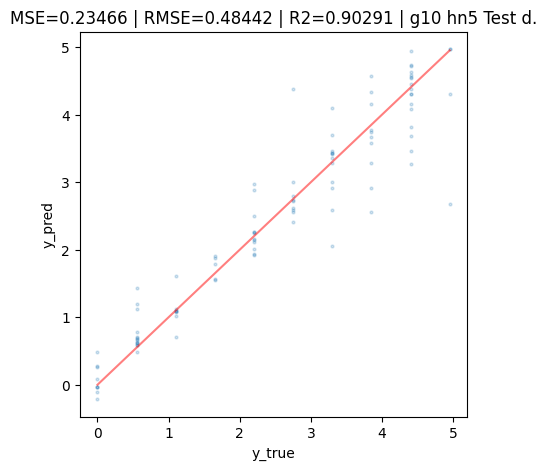

(0.23466218924716967, 0.902905930913837)

In [198]:
scatter_prediction_kan(model5_10, tc_x_train, tc_y_train, "g10 hn5 Train d.")
scatter_prediction_kan(model5_10, tc_x_test, tc_y_test, "g10 hn5 Test d.")

### Gradially increasing grid

In [199]:
width = [INPUT_SHAPE, 5, 1]
grids = np.array([3, 5, 7, 10])

train_losses = []
test_losses = []
steps = 50

for i in range(grids.shape[0]):
    print(i)
    if i == 0:
        model5_1_10 = KAN(width=width, grid=grids[i], k=K)
    if i != 0:
        model5_1_10  = KAN(width=width, grid=grids[i], k=K).initialize_from_another_model(model5_1_10 , dataset['train_input'])
    results = model5_1_10 .train(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=30)
    train_losses += results['train_loss']
    test_losses += results['test_loss']

0


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]

train loss: 2.75e-01 | test loss: 4.10e-01 | reg: 1.84e+01 : 100%|██| 50/50 [01:11<00:00,  1.44s/it]


1


train loss: 2.64e-01 | test loss: 4.23e-01 | reg: 1.86e+01 : 100%|██| 50/50 [01:09<00:00,  1.39s/it]


2


train loss: 2.43e-01 | test loss: 4.32e-01 | reg: 1.89e+01 : 100%|██| 50/50 [01:19<00:00,  1.59s/it]


3


train loss: 2.19e-01 | test loss: 4.45e-01 | reg: 1.84e+01 : 100%|██| 50/50 [01:19<00:00,  1.58s/it]


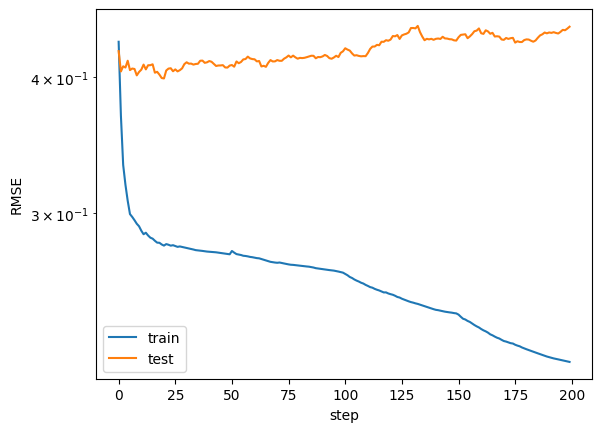

In [201]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

### Pruning

In [ ]:
model2 = model.prune()
model2(dataset['train_input'])
model2.plot()

# Energy instead length

Get wavelength transfer them from [nm] to energy [eV] according to formula:
$$ E=\frac{hc}{\lambda}=\frac{6.62607*2.99792}{1.60218}*10^{2}*\frac{1}{\lambda}  eV$$ 

In [152]:
l_wavelenth = get_wavelength(spec_file=""+SPEC_FOLDER)
l_energ = 6.62607*2.99792/1.60218*10**2 / l_wavelenth

In [153]:
plotly_multi_scatter([(l_wavelenth, x.loc[x.index[0]].values),
                      (l_wavelenth, x.loc[x.index[1]].values),
                      (l_wavelenth, x.loc[x.index[3]].values)], 
                     main_title="FL on 350 nm excitation", x_title="k, nm", y_title="Intensity")

[251. 252. 253. 254. 255.] [2.358 2.249 0.788 2.067 2.199]
[251. 252. 253. 254. 255.] [5.769 3.68  4.35  5.62  3.09 ]
[251. 252. 253. 254. 255.] [3.075 2.551 1.681 1.908 2.565]


In [154]:
plotly_multi_scatter([(l_energ, x.loc[x.index[0]].values),
                      (l_energ, x.loc[x.index[1]].values),
                      (l_energ, x.loc[x.index[-1]].values)], 
                     main_title="FL on 350 nm excitation", x_title="Energy, eV", y_title="Intensity")

[4.93959146 4.91998991 4.90054331 4.88124983 4.86210768] [2.358 2.249 0.788 2.067 2.199]
[4.93959146 4.91998991 4.90054331 4.88124983 4.86210768] [5.769 3.68  4.35  5.62  3.09 ]
[4.93959146 4.91998991 4.90054331 4.88124983 4.86210768] [3.151 2.479 2.284 3.149 2.345]
